<a href="https://colab.research.google.com/github/abhilashhn1993/Sentiment_Analysis_of_Tweets/blob/master/All_Tweets_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install spacy
!pip install pyLDAvis
!pip install corextopic

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
import nltk; 
nltk.download('stopwords')

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [0]:
#remove been, being, haven't, don't, couldn't, didn't
stop_words.remove("don't")
stop_words.remove("been")
stop_words.remove("being")
stop_words.remove("haven't")
stop_words.remove("couldn't")
stop_words.remove("didn't")

In [0]:
#Adding Extra Stopwords to be removed from the dataset
stop_words.extend(['http', 'https', 'twitter', 'www', 'instagram', 'zsgdbw', 'tmblr', 'co', 'twitch','facebook', 'snapchat'])
stop_words.extend(['make','really','see','go','would','even','get','com','be','year','still','do','know','actually','much', 'let','s','have','name','photo'])
stop_words.extend(['back','today','day','last','thing','kit','stream','amp'])

#some custom keywords frequently seen in the dataset
stop_words.extend(['trinawolfy','trinawolfy','riyenrootsmusic'])
len(stop_words)

In [0]:
import string
#METHODS FOR TEXT CLEANING#

#text punctuation removal
def remove_punctuation(text):
  for p in string.punctuation:
    text = text.replace(p,'')
  return text

#method for pre-processing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Method for stopwords removal
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Method for text Lemmatization with POS tagging
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#Method to remove texts with consecutive characters
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

#Method to convert the cleaned tweets back into string
def convert_to_string(df):
  for row in range(len(df)):
    df.iloc[row].Tweets = ' '.join([str(element) for element in df.iloc[row].Tweets])
  return df

In [0]:
def cleanTweets(df):
	# Convert to list
	df['Tweets'] = df.Tweets.values.tolist()

	# Remove Emails
	df['Tweets'] = [re.sub('\S*@\S*\s?', '', sent) for sent in df['Tweets']]
	# Remove new line characters
	df['Tweets'] = [re.sub('\s+', ' ', sent) for sent in df['Tweets']]
	# Remove Punctuations
	df['Tweets'] = df.Tweets.apply(remove_punctuation)
	# Remove distracting single quotes
	df['Tweets'] = [re.sub("\'", "", sent) for sent in df['Tweets']]
	# Remove consecutive characters
	df['Tweets'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")

	df['Tweets'] = list(sent_to_words(df['Tweets']))
	df['Tweets'] = remove_stopwords(df['Tweets'])

	# Initialize spacy 'en' model
	df['Tweets'] = lemmatization(df['Tweets'], allowed_postags=['NOUN','ADJ','VERB','ADV'])

	# remove the stopwords again after lemmatizing the text
	df['Tweets'] = remove_stopwords(df['Tweets'])

	df = convert_to_string(df)
	df = df.drop([0], axis=0)
	return df

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import io
df_all = pd.read_csv(io.BytesIO(uploaded['All_User_Tweets.csv']))

In [0]:
df_all = df_all.rename(columns={'No. of Tweets': 'TweetCount'})
df_all.head()

In [0]:
df_all = cleanTweets(df_all)

In [0]:
#Just in case pandas encounters the SettingWithCopyWarning 
df_all['Tweets'] = df_all['Tweets'].str.join(" ")
df_all.head()

**Topic Modeling**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.5,
    min_df=10,
    max_features=None,
    ngram_range=(1, 2),
    norm=None,
    binary=True,
    use_idf=False,
    sublinear_tf=False
)

In [0]:
vectorizer = vectorizer.fit(df_all['Tweets'])
tfidf = vectorizer.transform(df_all['Tweets'])
vocab = vectorizer.get_feature_names()
print(len(vocab))

In [0]:
from corextopic import corextopic as ct
#Unsupervised Anchor corex
anchors = []
unsup_model = ct.Corex(n_hidden=4, seed=42)
unsup_model = unsup_model.fit(
    tfidf,
    words=vocab
)

In [17]:
for i, topic_ngrams in enumerate(unsup_model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: say, woman, trump, chinese, call, government, cop, man, country
Topic #2: time, take, think, work, come, give, first, use, also, may
Topic #3: tell, mental, many, health, hear, pk, never, family, talk, friend
Topic #4: people, good, feel, life, help, way, want, could, need, try


In [0]:
#Supervised Corex with Anchors provided
anchors = [
           ["trauma","accident","flashbacks","abuse","assault","disabled","break up","sexual assault","harassment","torture","war","battle"], #CAUSES
           ["sad","alone","bad","hurt","feel","pain","scared","angry","fuck","shit","yell","lost","fuck","shit","annoyed","let down"], #FEELINGS AND EMOTIONS
           ["depressed","anxiety","stress","nightmare","sleep","insomnia","nervous","tired","fatigue","disorder","eating","suicide","nausea","no mood"], #SYMPTOMS BOTH PHYSICAL & MENTAL
           ["therapy","exercise","medications","drugs","pills","antidepressant","celexa","prazosin","mental health","care","support group","work out","gym","sessions",
            "healthy","meditate","yoga"] #TREATMENT & THERAPY
]
sup_model = ct.Corex(n_hidden=4, seed=42)
sup_model = sup_model.fit(
    tfidf,
    words=vocab,
    anchors=anchors,
    anchor_strength=5
)

In [19]:
for i, topic_ngrams in enumerate(sup_model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: people, war, abuse, torture, assault, trauma, say, battle, use, woman
Topic #2: feel, bad, shit, fuck, sad, alone, hurt, pain, angry, scared
Topic #3: sleep, anxiety, time, tired, stress, come, good, suicide, try, week
Topic #4: care, mental health, take, therapy, help, think, need, healthy, work, want


**Creating dataframe with topics**

In [0]:
topic_df = pd.DataFrame(
    sup_model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range(4)]
    ).astype(float)

In [0]:
topic_df.index = df_all.index
df_topics = pd.concat([df_all, topic_df], axis=1)
df_topics.sample(10, random_state=123)

In [0]:
#Concatenate by username and Ptsd flag variable for the All PTSD dataset
data_tweets = df_topics.groupby(['Username','Ptsd','Gender','Following','Followers','TweetCount'], as_index=False).agg({'topic_1':'mean', 'topic_2':'mean',
                                                                                                                        'topic_3': 'mean', 'topic_4': 'mean', 'Tweets': ' '.join})

In [0]:
data_tweets.head()

In [0]:
data_tweets= data_tweets.drop(['Gender'], axis=1)

In [0]:
data_tweets.to_csv('All_Tweets_topic_features.csv')

In [0]:
files.download('All_Tweets_topic_features.csv')

**Train and Test Data split based on 70-30 ratio**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_tweets.iloc[:,2:9],data_tweets['Ptsd'], test_size=0.3, random_state=1)

In [0]:
X_train.shape

In [0]:
X_test.shape

In [0]:
y_test.shape

In [0]:
y_train.shape

**LOGISTIC REGRESSION MODEL WITH K-FOLD CROSS VALIDATION**

In [0]:
from sklearn.linear_model.logistic import LogisticRegression
logReg = LogisticRegression()

In [0]:
logReg.fit(X_train,y_train)

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score

**Model Validation on the Test data**

In [0]:
scores = cross_val_score(logReg, X_test, y_test, cv=5)

In [36]:
print("Accuracy is", scores.mean()*100, "percent")

Accuracy is 70.0 percent


In [0]:
predictions = logReg.predict(X_test)

In [38]:
pred_score = logReg.score(X_test, y_test)
print(pred_score*100)

52.77777777777778


**CONFUSION MATRIX**

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
conf = metrics.confusion_matrix(y_test, predictions)
print(conf)

[[ 0 17]
 [ 0 19]]


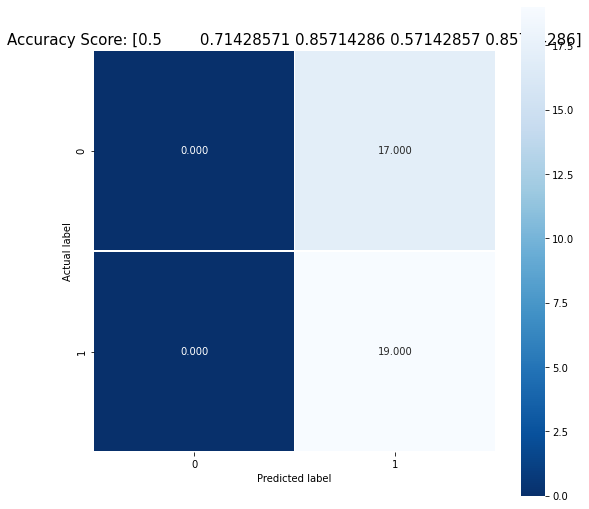

In [41]:
plt.figure(figsize=(9,9))
sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(scores)
plt.title(all_sample_title, size = 15);